In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

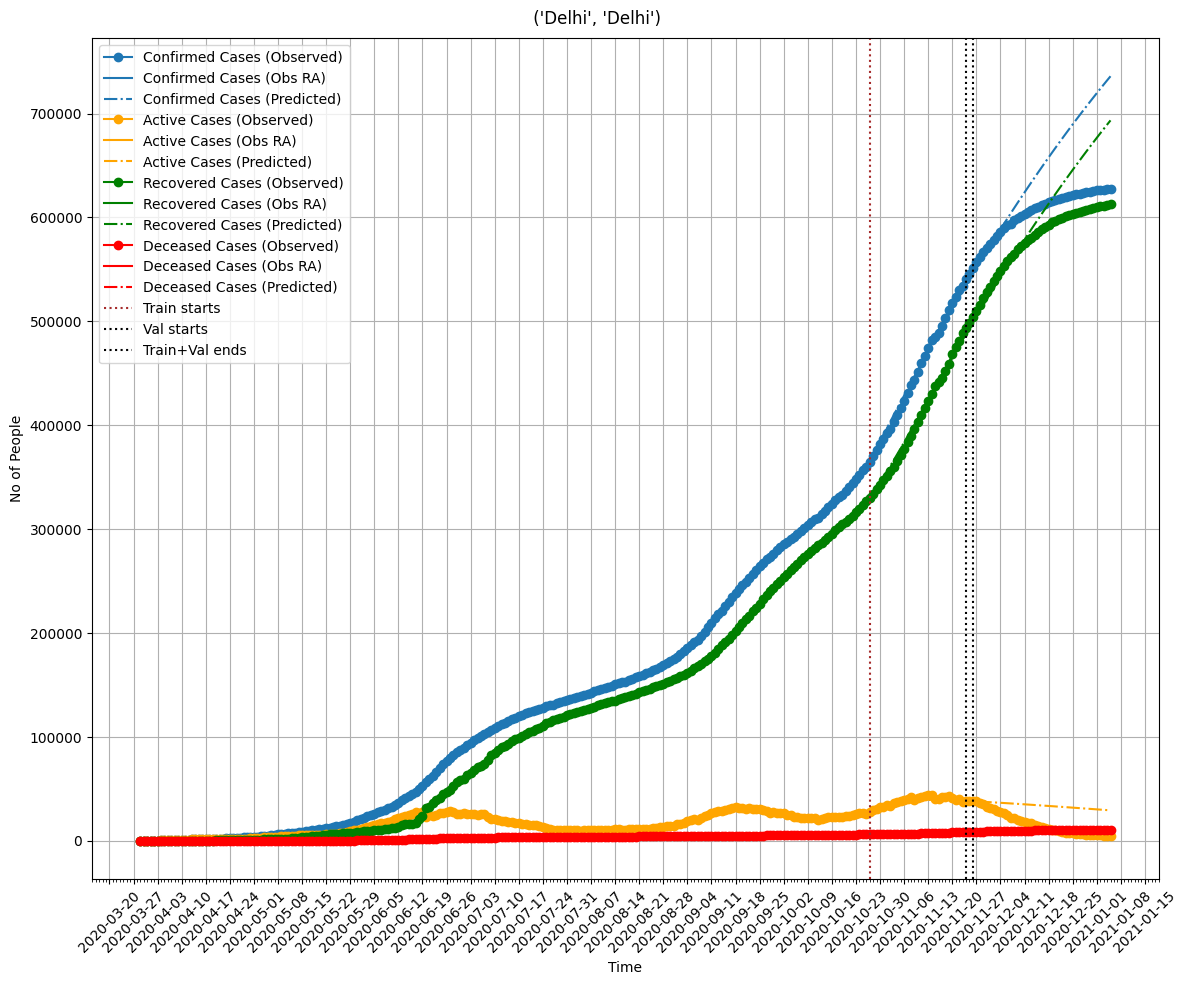

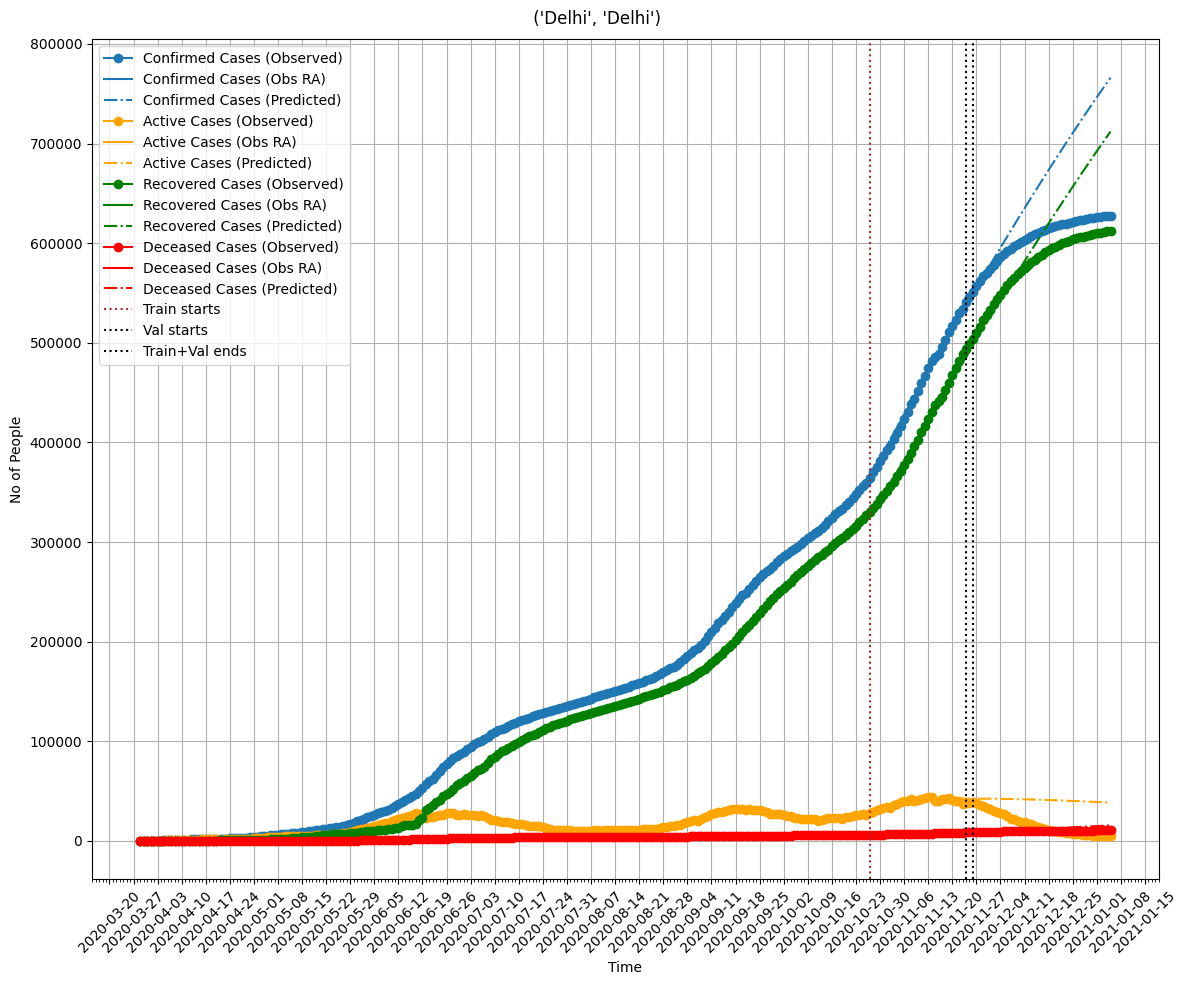

In [4]:
import pickle as pkl
with open('../../misc/predictions/test_mumbai.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [16]:
PD['m0']['MCMC']['m1']['df_prediction'].keys()

Index(['date', 'S', 'E', 'I', 'R_recov', 'R_fatal', 'C', 'D', 'active',
       'recovered', 'deceased', 'total'],
      dtype='object')

In [6]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [7]:
config['forecast']['plot_ptiles_for_columns']

[<Columns.total: Column(name='total', label='Confirmed Cases', color='C0')>]

In [27]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_prediction']

,date,total,active,recovered,deceased
0,2020-10-27,365772.0000,28508.0000,330916.0000,6348.0000
1,2020-10-28,369636.4070,29421.4525,333824.5795,6390.3750
2,2020-10-29,373935.5465,30661.3535,336837.8585,6436.3345
3,2020-10-30,378465.3920,32003.2875,339975.8420,6486.2625
4,2020-10-31,383109.0760,33327.9590,343240.9485,6540.1685
...,...,...,...,...,...
77,2021-01-12,595773.9765,18810.1100,563793.5620,13170.3045
78,2021-01-13,597309.5630,18516.2885,565548.3060,13244.9685
79,2021-01-14,598820.7635,18226.7680,567275.2360,13318.7595
80,2021-01-15,600308.0625,17941.4935,568974.8415,13391.7275


{<Columns.total: Column(name='total', label='Confirmed Cases', color='C0')>: <Figure size 864x864 with 1 Axes>}

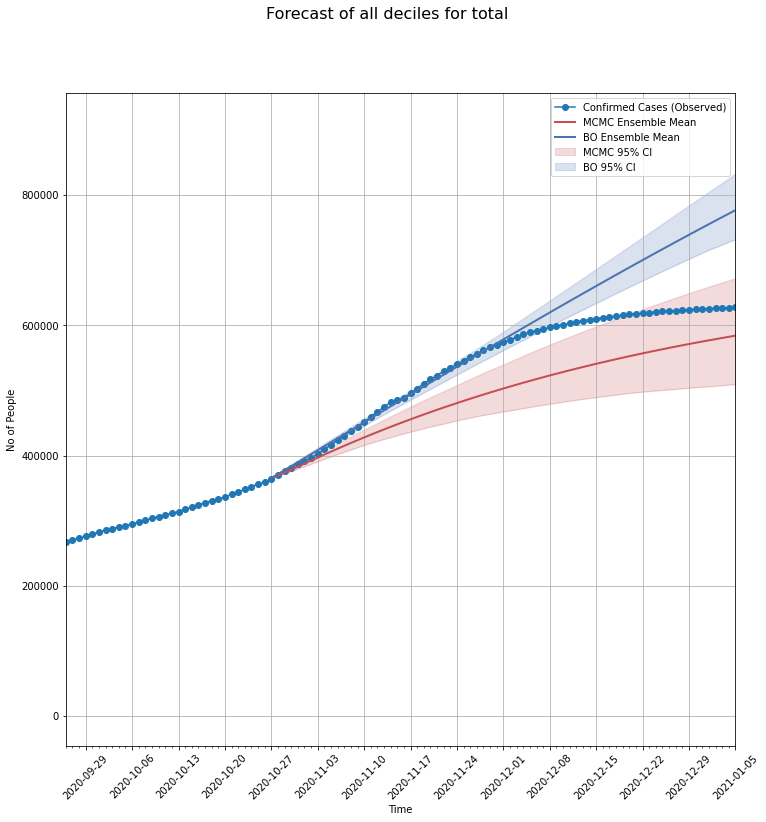

In [32]:
plot_ptiles_comp(PD['m1'], which_compartments=config['forecast']['plot_ptiles_for_columns'])

In [11]:
import matplotlib as mpl
## for Palatino and other serif fonts use:
plt.rcParams.update({
    'font.size': 15,
    'font.family': 'Palatino',
 })

In [12]:
import pandas as pd
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 10.00484948553936,
 'recovered': 0.8057774083739712,
 'deceased': 3.3732772778933233,
 'total': 0.6407587064488834}

In [13]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [44]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['test']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [45]:
np.linspace(0,100,42)

array([  0.        ,   2.43902439,   4.87804878,   7.31707317,
         9.75609756,  12.19512195,  14.63414634,  17.07317073,
        19.51219512,  21.95121951,  24.3902439 ,  26.82926829,
        29.26829268,  31.70731707,  34.14634146,  36.58536585,
        39.02439024,  41.46341463,  43.90243902,  46.34146341,
        48.7804878 ,  51.2195122 ,  53.65853659,  56.09756098,
        58.53658537,  60.97560976,  63.41463415,  65.85365854,
        68.29268293,  70.73170732,  73.17073171,  75.6097561 ,
        78.04878049,  80.48780488,  82.92682927,  85.36585366,
        87.80487805,  90.24390244,  92.68292683,  95.12195122,
        97.56097561, 100.        ])

In [46]:
df_compiled['MCMC'][0]

total         1.49991
active        12.5296
recovered     2.50395
deceased     0.552404
agg           4.27148
Name: test, dtype: object

In [47]:
import pandas as pd
stats = {}
stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]

In [48]:
stats['BO'].loc[['mean']]

,total,active,recovered,deceased,agg
mean,0.882134,22.838249,1.172692,3.52428,7.104339


## Comparing best loss from MCMC vs BO

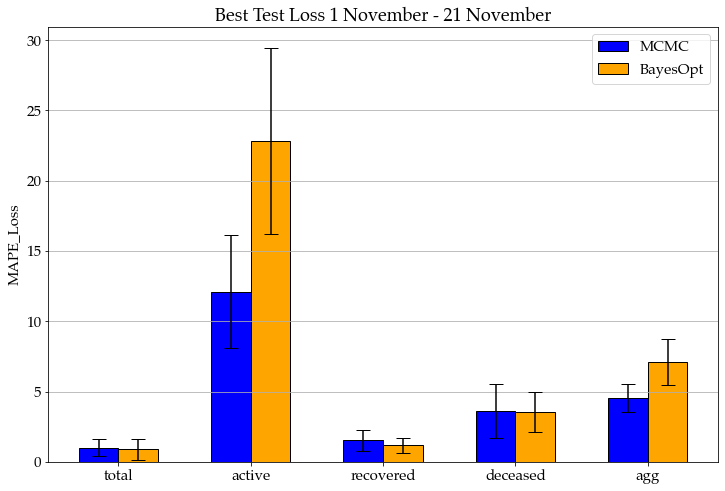

In [49]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Test Loss 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()


## Comparing Ensemble loss from MCMC vs BO

In [50]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 10.00484948553936,
 'recovered': 0.8057774083739712,
 'deceased': 3.3732772778933233,
 'total': 0.6407587064488834,
 'agg': 3.7061657195638853}

In [51]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [52]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

In [53]:
pd.DataFrame(df_compiled_ens['BO'])

,total,active,recovered,deceased,agg
0,NaN,NaN,NaN,NaN,NaN
1,0.672967,11.586526,1.378449,3.658463,4.324101
2,2.351435,4.471065,2.323683,10.570346,4.929132
3,2.409809,4.757983,2.173395,10.987558,5.082186
4,2.429444,5.075072,2.290327,9.748653,4.885874
5,1.415422,6.453660,1.578958,9.657933,4.776493
6,2.886839,5.015900,2.641493,11.096463,5.410174
7,1.667160,4.818134,1.418525,11.342197,4.811504
8,2.587775,9.031221,1.924768,11.826008,6.342443
9,2.359938,5.739170,2.637149,6.308993,4.261313


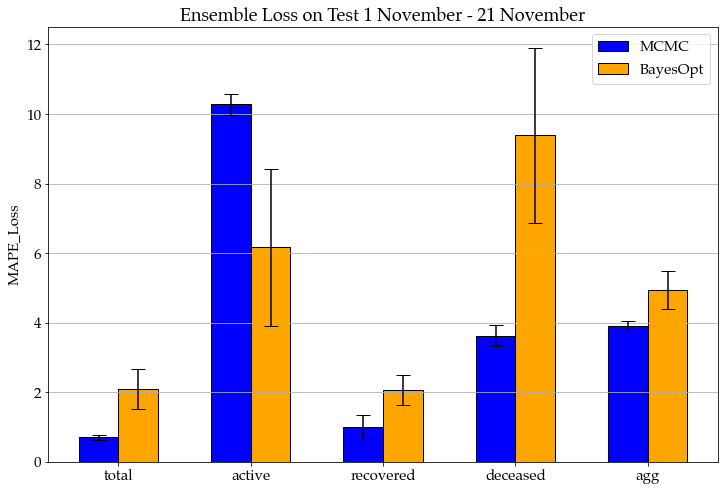

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Test 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [25]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

{'MCMC': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 'BO': [6.655975964426768,
  3.715575190306212,
  3.651540547623692,
  3.618006631695036,
  3.6217725442372477,
  3.664012439257461,
  3.638414339433442,
  3.6550891909340377,
  3.6799357078615045,
  3.6976984708198883,
  3.736614043861504,
  3.5626975062158444,
  3.8862596975880197,
  3.754798313863883,
  3.675210547186118]}

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-pack

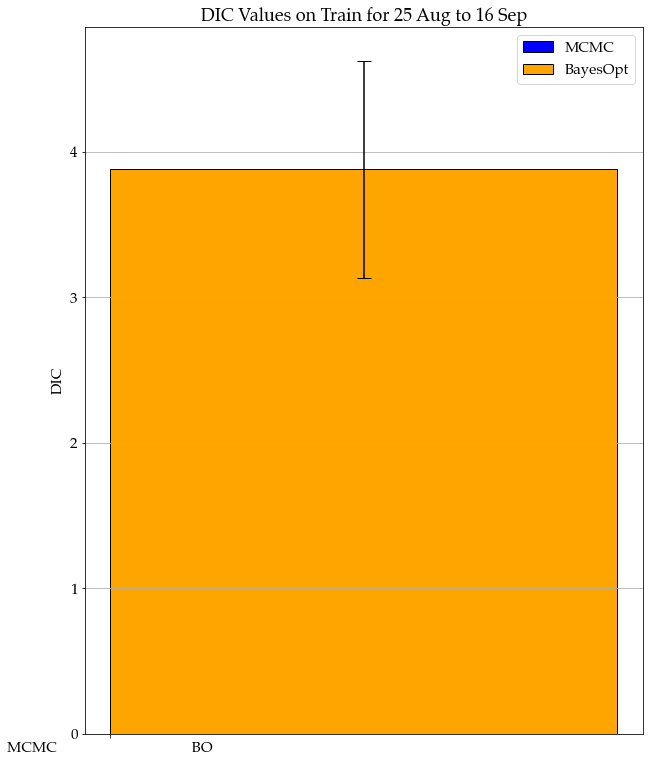

In [26]:
barWidth = 0.3
plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

## Percentile Loss

In [27]:
PD['m0']['MCMC']['uncertainty_forecasts'].keys()

dict_keys([2.43902439, 4.87804878, 7.31707317, 9.75609756, 12.19512195, 14.63414634, 17.07317073, 19.51219512, 21.95121951, 24.3902439, 26.82926829, 29.26829268, 31.70731707, 34.14634146, 36.58536585, 39.02439024, 41.46341463, 43.90243902, 46.34146341, 48.7804878, 51.2195122, 53.65853659, 56.09756098, 58.53658537, 60.97560976, 63.41463415, 65.85365854, 68.29268293, 70.73170732, 73.17073171, 75.6097561, 78.04878049, 80.48780488, 82.92682927, 85.36585366, 87.80487805, 90.24390244, 92.68292683, 95.12195122, 97.56097561])

In [28]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [29]:
pd.DataFrame(df_compiled_perc_loss['MCMC'])

,2.439024,4.878049,7.317073,9.756098,12.195122,14.634146,17.073171,19.512195,21.951220,24.390244,...,75.609756,78.048780,80.487805,82.926829,85.365854,87.804878,90.243902,92.682927,95.121951,97.560976
0,0.262842,0.436598,0.571050,0.657653,0.737125,0.800590,0.852758,0.885031,0.907529,0.919807,...,0.842538,0.848342,0.841636,0.810526,0.777836,0.729441,0.658937,0.559178,0.420677,0.256320
1,0.245865,0.389371,0.503476,0.580168,0.655542,0.719964,0.772620,0.784639,0.799658,0.793669,...,0.837694,0.844556,0.827858,0.810730,0.778840,0.713076,0.662711,0.579143,0.440278,0.285362
2,0.259155,0.432563,0.570267,0.673819,0.756863,0.821352,0.881220,0.922820,0.948926,0.970230,...,0.805784,0.807478,0.786857,0.762519,0.738611,0.694738,0.640058,0.545838,0.409113,0.247315
3,0.310665,0.492687,0.639361,0.769750,0.852153,0.917888,0.966950,1.002165,1.021865,1.033568,...,0.778170,0.789360,0.799477,0.785919,0.735239,0.709102,0.644456,0.532585,0.401327,0.250839
4,0.234848,0.412837,0.547626,0.670888,0.769727,0.849907,0.915244,0.961911,0.971195,0.952333,...,0.699926,0.731184,0.718912,0.702476,0.681999,0.655160,0.592062,0.498396,0.374213,0.222588
5,0.271698,0.420711,0.533990,0.628120,0.711577,0.773806,0.840349,0.893195,0.926968,0.948405,...,0.676350,0.695441,0.699115,0.685546,0.657367,0.618565,0.570742,0.479551,0.358996,0.216908
6,0.352066,0.528567,0.638253,0.719839,0.791518,0.869656,0.923730,0.942003,0.949756,0.932879,...,0.823144,0.822279,0.817057,0.796575,0.765392,0.709607,0.639022,0.542495,0.416264,0.253042
7,0.219118,0.377062,0.513541,0.608402,0.681516,0.758659,0.799667,0.835202,0.837909,0.849524,...,0.776685,0.775759,0.775623,0.773590,0.744947,0.695582,0.615992,0.520306,0.384388,0.222146
8,0.315304,0.470051,0.581691,0.682922,0.772324,0.851857,0.898937,0.927875,0.960614,0.984279,...,0.786540,0.783155,0.796985,0.793396,0.749201,0.719771,0.649007,0.557917,0.426956,0.260046
9,0.235470,0.407352,0.548118,0.635520,0.712224,0.770512,0.807957,0.842597,0.855706,0.854736,...,0.755755,0.768167,0.758099,0.728394,0.700869,0.645174,0.578953,0.500594,0.384801,0.226781


In [30]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

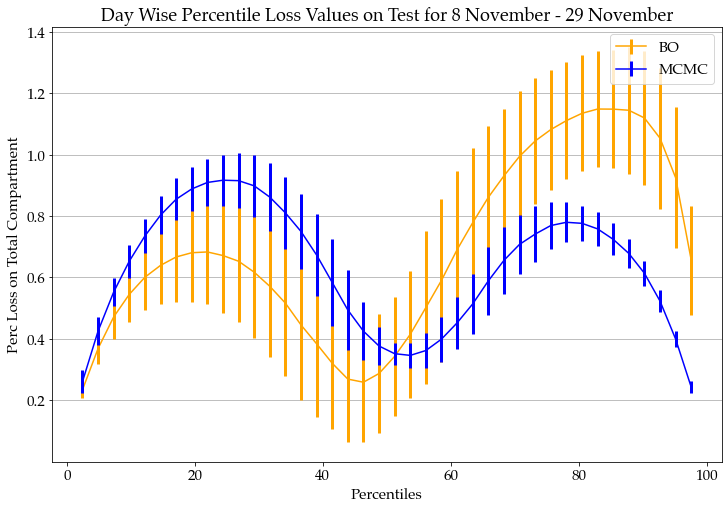

In [32]:
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Test for 8 November - 29 November')
plt.legend()
 
# Show graphic
plt.show()

In [33]:
from viz.fit import plot_comp_density_plots,plot_histogram

(<Figure size 864x1224 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Denisty Plot of parameter E_hosp_ratio'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter I_hosp_ratio'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter P_fatal'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_inc'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_inf'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_recov'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_Death'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter lockdown_R0'}, ylabel='Density'>]],
       dtype=object))

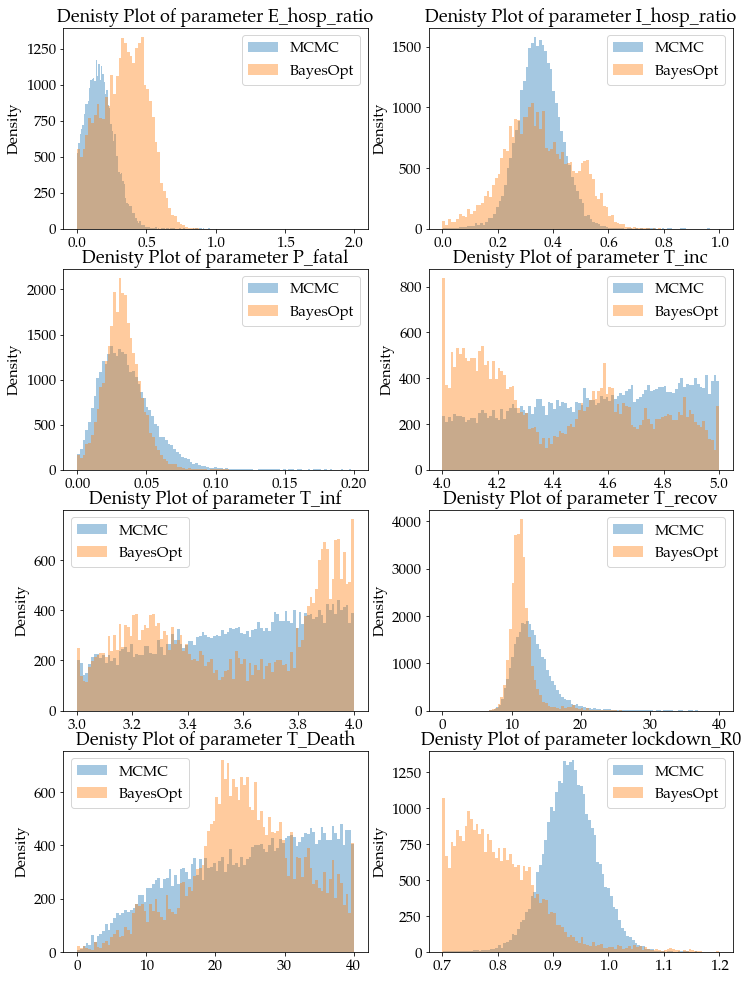

In [39]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
X= {}
plot_comp_density_plots(PD,figs,axs)
